In [136]:

%load_ext autoreload
%autoreload 2

import sys
import os
import json
import pandas as pd
import MDAnalysis as mda
from utils import utils
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sbmlcore
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from catomatic.CatalogueBuilder import BuildCatalogue
from scipy.stats import ttest_ind
import seaborn as sns

from PIL import Image



sys.path.append(os.path.abspath('ml-models'))
from mlmodels.Models import Models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# We have an issue with unstable performance - this notebook investigates that (delete once sorted)

# Data Import

In [2]:
solos = pd.read_csv('./data/tables/generated/rpoB_solos.csv')
solos

,Unnamed: 0,mutation,segid,PHENOTYPE,resid
0,0,A1002P,C,S,1002
1,1,A286V,C,R,286
2,2,A29T,C,S,29
3,3,A29V,C,S,29
4,4,A334D,C,S,334
...,...,...,...,...,...
301,301,V895F,C,S,895
302,302,V946G,C,S,946
303,303,Y308C,C,R,308
304,304,Y572C,C,S,572


In [3]:
data = pd.read_csv('./data/tables/generated/features_dataset.csv', index_col=0)

#replace R/S labels with binary 1/0
data['phenotype'] = [1 if i =='R' else 0 for i in data.PHENOTYPE]
#remove dynamic features generated from md simulations - will explore later
data = data.drop(columns=[col for col in data.columns if 'min' in col or 'mean' in col])

data

,segid,resid,mutation,PHENOTYPE,d_volume,d_hydropathy_KD,d_MW,d_pi,d_rogov,Rif_distance,...,psi,n_hbond_acceptors,n_hbond_donors,SASA,snap2_score,deep_ddG,rasp_score,temp_factor,secondary_structure,phenotype
0,C,1002,A1002P,S,24.1,-3.4,26.0,0.30,0.020,45.415055,...,164.84,1.0,1.0,7.268116,36,-2.927,0.800033,36.009998,0,0
1,C,286,A286V,R,51.4,2.4,28.0,-0.04,0.232,47.831892,...,-17.70,0.0,1.0,0.000000,-31,-0.523,0.222401,121.500000,1,1
2,C,29,A29T,S,27.5,-2.5,30.0,-0.40,0.248,34.306893,...,161.38,0.0,0.0,34.753706,-81,-1.142,0.328659,32.820000,2,0
3,C,29,A29V,S,51.4,2.4,28.0,-0.04,0.232,34.306893,...,161.38,0.0,0.0,34.753706,-76,-1.056,0.284229,32.820000,2,0
4,C,334,A334D,S,22.5,-5.3,44.0,-3.23,0.029,43.228183,...,-16.26,1.0,1.0,0.786252,-54,-2.734,0.369132,102.089996,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,C,895,V895F,S,49.9,-1.4,48.1,-0.48,0.345,41.296670,...,-22.89,0.0,0.0,35.841417,-1,-1.014,0.287163,37.750000,3,0
302,C,946,V946G,S,-79.9,-4.6,-42.0,0.01,-0.080,53.471656,...,122.58,0.0,0.0,86.193134,-81,-0.444,0.424508,68.440002,2,0
303,C,308,Y308C,R,-85.1,3.8,-60.0,-0.59,-0.199,33.128330,...,-35.81,1.0,1.0,70.874065,68,-1.361,0.467171,76.190002,1,1
304,C,572,Y572C,S,-85.1,3.8,-60.0,-0.59,-0.199,37.911061,...,172.92,1.0,1.0,27.871431,35,-1.543,0.563006,61.090000,0,0


In [4]:
features = data.columns[4:]
feature_data = data[features]

### As is

In [5]:
#use ml-models to determine best model and decision threshold, on most data - gives us something to work with
model = Models(
        {"all": feature_data},
        'LR',
        "average_precision",
        random_seed=0,
        test_fraction=0.05,
        verbose=False,
        output_plots=False,
    )

est = model.opt_estimator
thresh = model.opt_threshold

In [6]:
feature_data

,d_volume,d_hydropathy_KD,d_MW,d_pi,d_rogov,Rif_distance,Mg_distance,Zn1_distance,Zn2_distance,antisense_P_distance,...,psi,n_hbond_acceptors,n_hbond_donors,SASA,snap2_score,deep_ddG,rasp_score,temp_factor,secondary_structure,phenotype
0,24.1,-3.4,26.0,0.30,0.020,45.415055,31.783345,65.820752,89.775208,57.975782,...,164.84,1.0,1.0,7.268116,36,-2.927,0.800033,36.009998,0,0
1,51.4,2.4,28.0,-0.04,0.232,47.831892,64.028439,75.109206,67.294269,40.591519,...,-17.70,0.0,1.0,0.000000,-31,-0.523,0.222401,121.500000,1,1
2,27.5,-2.5,30.0,-0.40,0.248,34.306893,40.030977,81.478877,81.622597,55.169772,...,161.38,0.0,0.0,34.753706,-81,-1.142,0.328659,32.820000,2,0
3,51.4,2.4,28.0,-0.04,0.232,34.306893,40.030977,81.478877,81.622597,55.169772,...,161.38,0.0,0.0,34.753706,-76,-1.056,0.284229,32.820000,2,0
4,22.5,-5.3,44.0,-3.23,0.029,43.228183,56.772771,74.510909,80.544569,41.085344,...,-16.26,1.0,1.0,0.786252,-54,-2.734,0.369132,102.089996,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,49.9,-1.4,48.1,-0.48,0.345,41.296670,28.986757,64.306366,76.613687,55.614045,...,-22.89,0.0,0.0,35.841417,-1,-1.014,0.287163,37.750000,3,0
302,-79.9,-4.6,-42.0,0.01,-0.080,53.471656,48.889279,84.665675,104.881637,68.230868,...,122.58,0.0,0.0,86.193134,-81,-0.444,0.424508,68.440002,2,0
303,-85.1,3.8,-60.0,-0.59,-0.199,33.128330,49.415429,75.024083,74.776429,38.607935,...,-35.81,1.0,1.0,70.874065,68,-1.361,0.467171,76.190002,1,1
304,-85.1,3.8,-60.0,-0.59,-0.199,37.911061,45.458752,77.264726,89.884146,48.693470,...,172.92,1.0,1.0,27.871431,35,-1.543,0.563006,61.090000,0,0


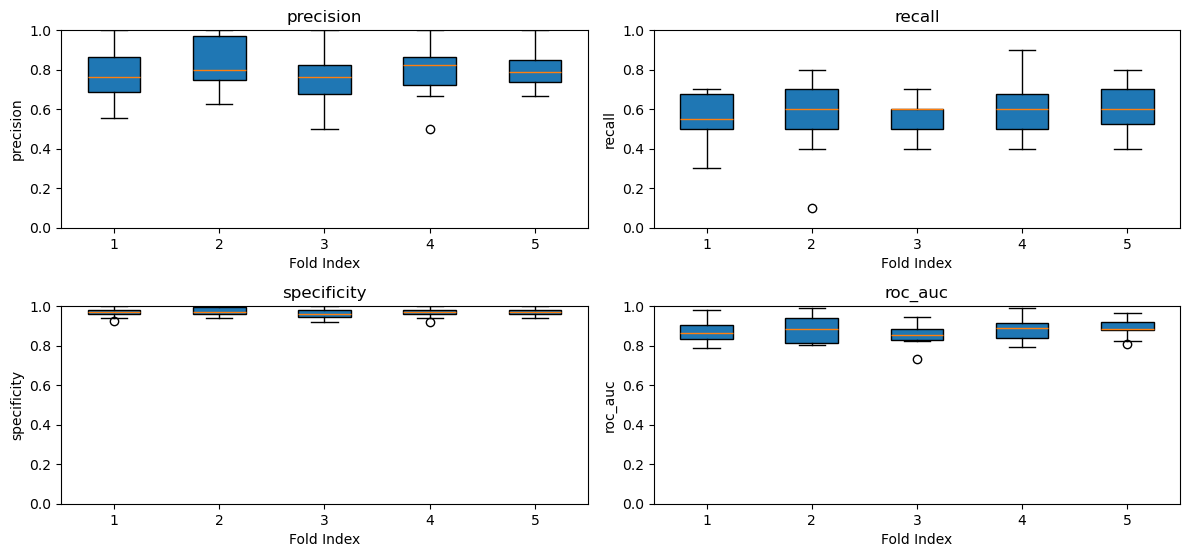

In [7]:
X = feature_data.drop(columns=['phenotype'])
y = feature_data['phenotype']

metrics = utils.repeated_kfold_evaluation(est, X, y, threshold=thresh, n_splits=5, n_repeats=10)

# Plot the results
plt.figure(figsize=(12, 8))

num_metrics = len(metrics)
for idx, metric in enumerate(metrics):
    plt.subplot(3, 2, idx+1)
    plt.boxplot(metrics[metric], notch=False, patch_artist=True)
    plt.title(metric)
    plt.xlabel('Fold Index')
    plt.ylim(0, 1)
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

### Upsample

In [182]:
#use ml-models to determine best model and decision threshold, on most data - gives us something to work with
model = Models(
        {"all": feature_data},
        'LR',
        "average_precision",
        random_seed=1,
        test_fraction=0.1,
        verbose=False,
        output_plots=False,
        upsample_coeff=3
    )

est = model.opt_estimator
thresh = model.opt_threshold

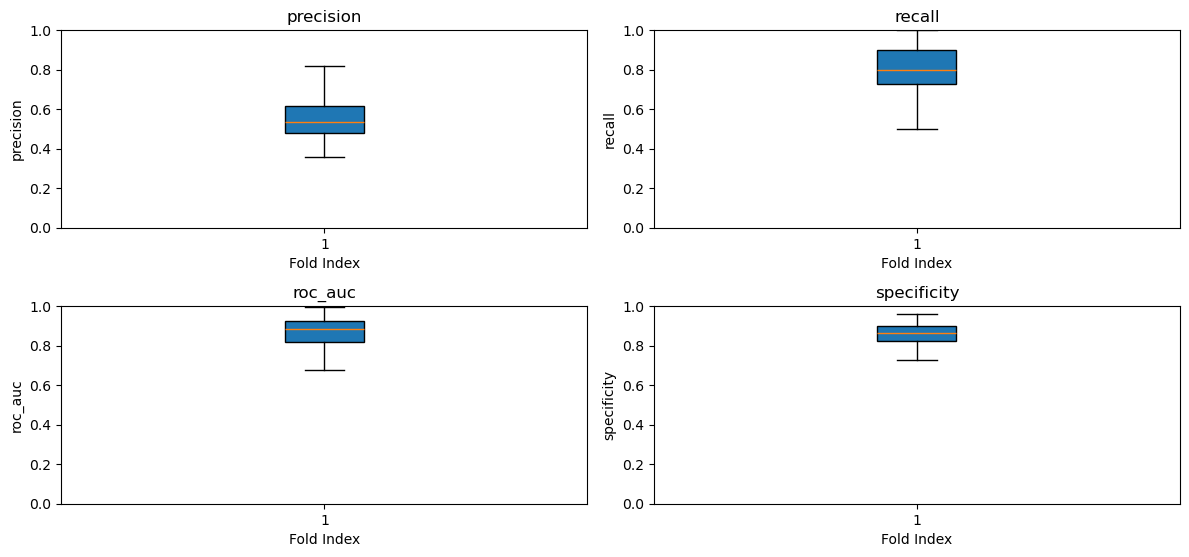

In [183]:
X = feature_data.drop(columns=['phenotype'])
y = feature_data['phenotype']

metrics = utils.repeated_kfold_evaluation(est, X, y, threshold=thresh, n_splits=5, n_repeats=10, upsample_R=3)
metrics = {metric: [item for sublist in values for item in sublist] for metric, values in metrics.items()}

# Plot the results
plt.figure(figsize=(12, 8))

num_metrics = len(metrics)
for idx, metric in enumerate(metrics):
    plt.subplot(3, 2, idx+1)
    plt.boxplot(metrics[metric], notch=False, patch_artist=True)
    plt.title(metric)
    plt.xlabel('Fold Index')
    plt.ylim(0, 1)
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

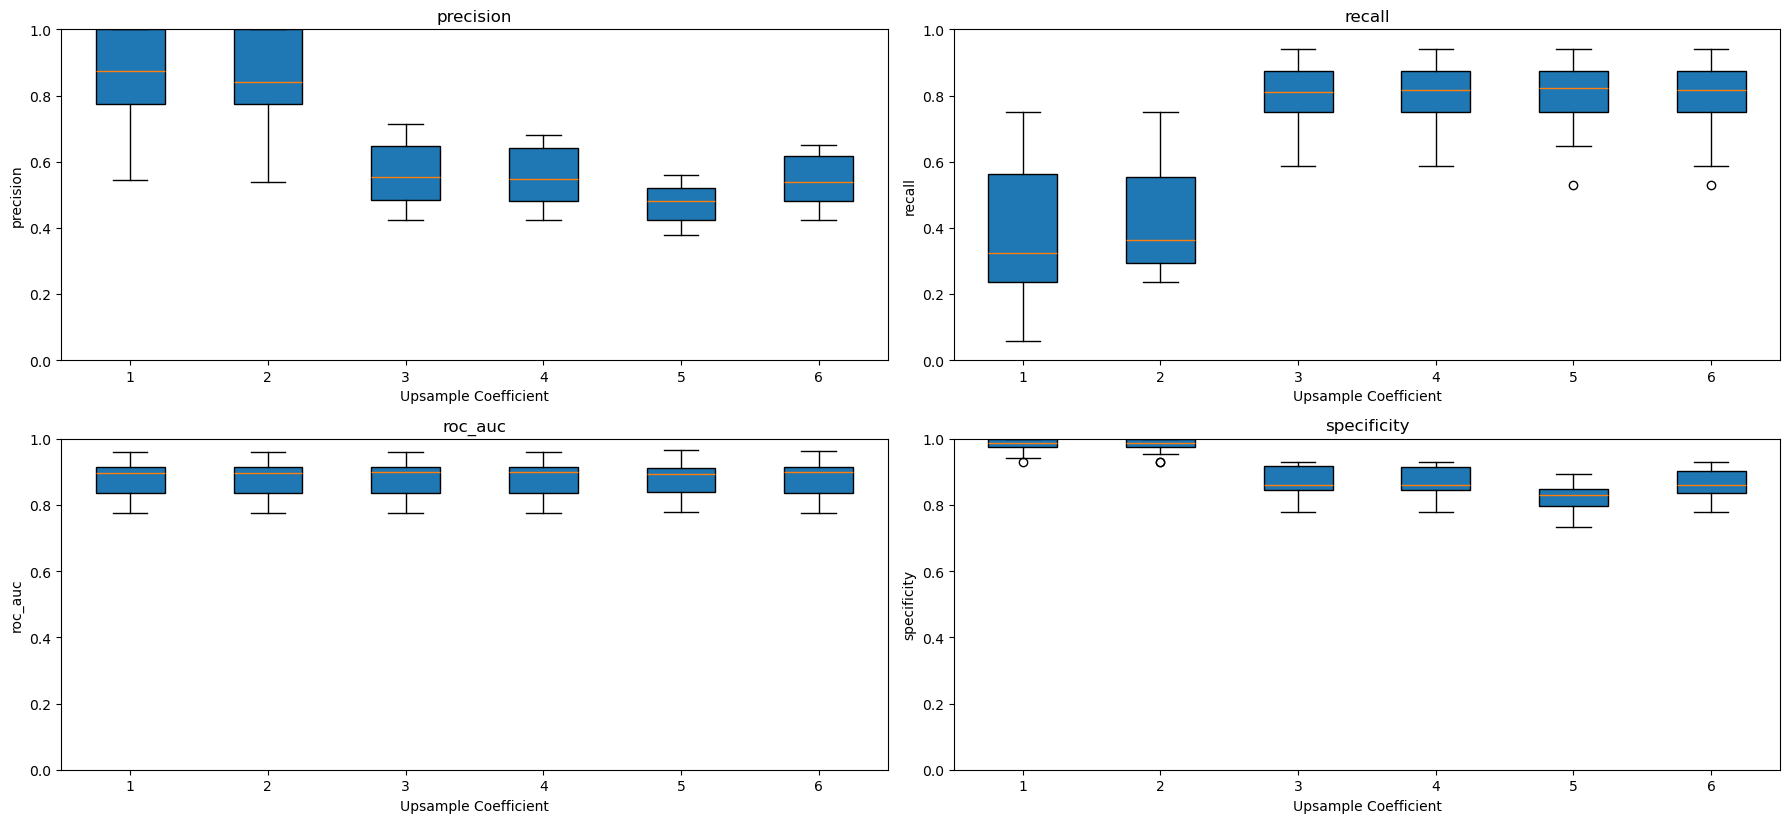

In [170]:
upsample_coefficients = [1, 2, 3, 4, 5]

# Initialize a dictionary to store the metrics for each upsample coefficient
all_metrics = {coef: {} for coef in upsample_coefficients}

# Loop over each upsample coefficient
for coef in upsample_coefficients:
    model = Models(
        {"all": feature_data},
        'LR',
        "average_precision",
        random_seed=1,
        test_fraction=0.1,
        verbose=False,
        output_plots=False,
        upsample_coeff=coef
    )

    est = model.opt_estimator
    thresh = model.opt_threshold
    X = feature_data.drop(columns=['phenotype'])
    y = feature_data['phenotype']

    metrics = utils.repeated_kfold_evaluation(est, X, y, threshold=thresh, n_splits=5, n_repeats=10, upsample_R=coef)
    metrics = {metric: [item for sublist in values for item in sublist] for metric, values in metrics.items()}
    
    all_metrics[coef] = metrics

# Plot the results
plt.figure(figsize=(18, 12))

num_metrics = len(metrics)
metrics_names = list(metrics.keys())
num_coefficients = len(upsample_coefficients)

for idx, metric in enumerate(metrics_names):
    plt.subplot(3, 2, idx+1)
    data_to_plot = [all_metrics[coef][metric] for coef in upsample_coefficients]
    plt.boxplot(data_to_plot, notch=False, patch_artist=True, labels=upsample_coefficients)
    plt.title(metric)
    plt.xlabel('Upsample Coefficient')
    plt.ylim(0, 1)
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

Upsampling does not reduce our variance in predictions - confidence limits remain the same width.

But, sensitivity does increase at the cost of false positives - so precistion and specificity drop. Therefore this becomes a question of comprimise.

However, once we remove indels we are left with only 46 resistant mutations (and fewer susceptible mutations than before owing to the strict data requirement for susceptible classifications)

# Which mutations are being classified incorreclty?

In [ ]:
# Initialize the dictionary for all mutations
mutation_stats = {mut: {'FP': 0, 'FN': 0, 'TN':0, 'TP':0} for mut in data['mutation']}

# Initialize model and other necessary variables (assuming Models is defined)
for i in range(0, 100):
    model = Models(
        {"all": feature_data},
        "LR",
        "average_precision",
        random_seed=i,
        test_fraction=0.25,
        verbose=False,
        output_plots=False,
        upsample_coeff=0,
    )

    X_train, y_train, X_test, y_test = (
        model.X_train_nd["all"],
        model.y_train_nd["all"],
        model.X_test_nd["all"],
        model.y_test_nd["all"],
    )
    est = model.opt_estimator
    thresh = model.opt_threshold

    est.fit(X_train, y_train)
    y_proba = est.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= thresh).astype(int)

    X_test_df = pd.DataFrame(X_test)
    X_test_df.columns = feature_data.drop(columns=['phenotype']).columns
    X_test_df.reset_index(drop=True, inplace=True)

    # Add predictions and true values to the test DataFrame
    X_test_df['y_test'] = y_test
    X_test_df['y_pred'] = y_pred

    # Identify false positives and false negatives using boolean indexing
    TNs_df =  X_test_df[(X_test_df['y_test'] == 0) & (X_test_df['y_pred'] == 0)]
    TPs_df =  X_test_df[(X_test_df['y_test'] == 1) & (X_test_df['y_pred'] == 1)]
    FPs_df = X_test_df[(X_test_df['y_test'] == 0) & (X_test_df['y_pred'] == 1)]
    FNs_df = X_test_df[(X_test_df['y_test'] == 1) & (X_test_df['y_pred'] == 0)]

    # Merge with feature_data to include the 'mutation' column
    FPs_merged = pd.merge(FPs_df, data, on=['d_volume', 'Rif_distance', 'Zn1_distance'], how='left')
    FNs_merged = pd.merge(FNs_df, data, on=['d_volume', 'Rif_distance', 'Zn1_distance'], how='left')
    TPs_merged = pd.merge(TPs_df, data, on=['d_volume', 'Rif_distance', 'Zn1_distance'], how='left')
    TNs_merged = pd.merge(TNs_df, data, on=['d_volume', 'Rif_distance', 'Zn1_distance'], how='left')

    # Update the mutation statistics dictionary
    for mut in TPs_merged['mutation']:
        mutation_stats[mut]['TP'] += 1

    for mut in TNs_merged['mutation']:
        mutation_stats[mut]['TN'] += 1

    for mut in FPs_merged['mutation']:
        mutation_stats[mut]['FP'] += 1

    for mut in FNs_merged['mutation']:
        mutation_stats[mut]['FN'] += 1

/Users/dylanadlard/miniforge3/envs/rif_manuscript/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dylanadlard/miniforge3/envs/rif_manuscript/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

In [ ]:
stats_df = pd.DataFrame(mutation_stats).T.reset_index().rename(columns={'index':'mutation'})
stats_df = pd.merge(stats_df, data[['mutation', 'Rif_distance', 'phenotype']], on=['mutation'], how='left')

# Define functions to calculate sensitivity and specificity
def calculate_sensitivity(tp, fn):
    if tp + fn == 0:
        return float('NaN')
    return tp / (tp + fn)

def calculate_specificity(tn, fp):
    if tn + fp == 0:
        return float('NaN')
    return tn / (tn + fp)

# Apply calculations
sensitivities = []
specificities = []

for index, row in stats_df.iterrows():
    if row['phenotype'] == 1:  # Resistant
        sensitivity = calculate_sensitivity(row['TP'], row['FN'])
        sensitivities.append(sensitivity)
        specificities.append(float('NaN'))
    elif row['phenotype'] == 0:  # Susceptible
        specificity = calculate_specificity(row['TN'], row['FP'])
        specificities.append(specificity)
        sensitivities.append(float('NaN'))

stats_df['Sensitivity'] = sensitivities
stats_df['Specificity'] = specificities

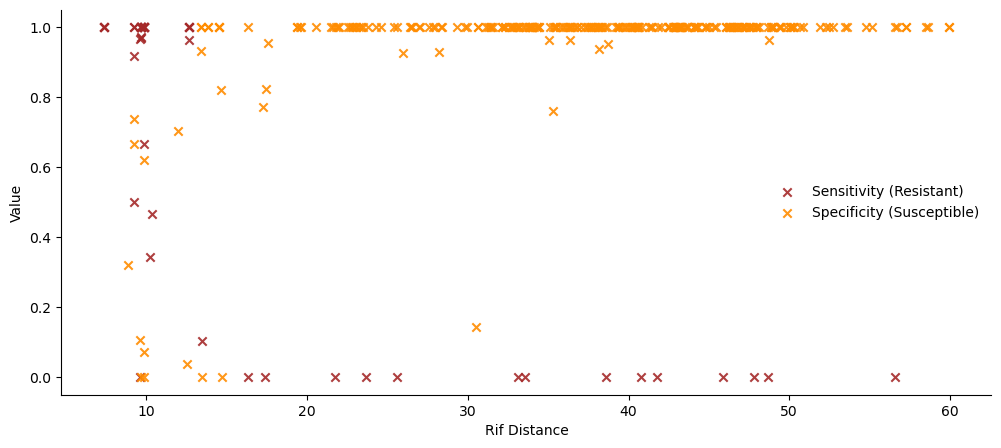

In [ ]:

# Separate data
resistant_mutations = stats_df[stats_df['phenotype'] == 1]
susceptible_mutations = stats_df[stats_df['phenotype'] == 0]

# Create the plot
plt.figure(figsize=(12, 5))
plt.scatter(resistant_mutations['Rif_distance'], resistant_mutations['Sensitivity'], marker='x', color='brown', label='Sensitivity (Resistant)', alpha=0.9)
plt.scatter(susceptible_mutations['Rif_distance'], susceptible_mutations['Specificity'], marker='x', color='darkOrange', label='Specificity (Susceptible)', alpha=0.9)

plt.xlabel('Rif Distance')
plt.ylabel('Value')

# Customize legend
legend = plt.legend()
legend.get_frame().set_linewidth(0)  # Remove legend frame

# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove grid lines
plt.grid(False)

plt.show()

In [407]:
FN_mutations = stats_df[(stats_df.Rif_distance>20)&(stats_df.phenotype==1)].mutation.tolist()
FN_mutations

['A286V',
 'D571Y',
 'D595E',
 'G981D',
 'K37R',
 'K891T',
 'L232R',
 'M707T',
 'Q409R',
 'V262A',
 'V496M',
 'Y308C']

Our false negatives are all mutations greater than 10 angstroms from the rif binding site.

These come from Charlotte's method of building dataset, which I think has captured errors by assuming anything with counts below 3 are the homogenous phenotype (if there is one).

What if we use catomatic to generate a dataset instead - it can be similarly liberal, but if we use a fishers test we should be able to get rid of those false negative samples.

# Let's see if we can generate a more balanced dataset

In [601]:
phenos = pd.read_pickle('data/tables/cryptic-tables-v2.1.2/DST_MEASUREMENTS.pkl.gz').reset_index()
genomes = pd.read_pickle('data/tables/cryptic-tables-v2.1.2/GENOMES.pkl.gz').reset_index()

if not os.path.exists("./data/tables/cryptic-tables-v2.1.2/rpoB_mutations.csv"):
    mutations = pd.read_pickle('data/tables/cryptic-tables-v2.1.2/MUTATIONS.pkl.gz').reset_index()
    #just catalogue rpoB for now - may produce more solos (under the assumption only rpoB is relevant)
    mutations = mutations[mutations.GENE=='rpoB']
    mutations.to_csv("./data/tables/cryptic-tables-v2.1.2/rpoB_mutations.csv")

mutations = pd.read_csv("./data/tables/cryptic-tables-v2.1.2/rpoB_mutations.csv")

phenos = phenos[
        (phenos.DRUG == 'RIF') & (phenos.PHENOTYPE.isin(["R", "S"]))
    ]

pheno_df = phenos.groupby("UNIQUEID", group_keys=False).apply(utils.filter_multiple_phenos).reset_index(drop=True)

samples = pd.merge(genomes, phenos, how='inner', on='UNIQUEID').reset_index()
samples = samples[["UNIQUEID", "DRUG", "PHENOTYPE", "METHOD_MIC", "QUALITY"]]

samples = samples[(samples.QUALITY.isin(["HIGH", "MEDIUM"]))]

mutations["GENE_MUT"] = [
    f"{row['GENE']}@{row['MINOR_MUTATION'] if row['IS_MINOR_ALLELE'] else row['MUTATION']}"
    for _, row in mutations.iterrows()
]

mutations["IS_SYNONYMOUS"] = [
    row["MUTATION"][0] == row["MUTATION"][-1] for _, row in mutations.iterrows()
]
mutations = mutations[~mutations.IS_SYNONYMOUS]

mutations["FRS"] = [
    1 if ~mutations["IS_MINOR_ALLELE"][i] else mutations["FRS"][i]
    for i in mutations.index
]

mutations["IS_NULL"] = mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][-1]  == 'Z'
)
mutations = mutations[~mutations.IS_NULL]


/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_11118/410117086.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pheno_df = phenos.groupby("UNIQUEID", group_keys=False).apply(utils.filter_multiple_phenos).reset_index(drop=True)


In [607]:
with open('./data/temp/wildcards.json', 'r') as f:
    wildcards = json.load(f)

In [608]:
# build catalogue without phenotyping
# assume homogenous S = Susceptible for purporses of recording max variants
catalogue = BuildCatalogue(
    samples=samples,
    mutations=mutations,
    FRS=0.1,
    test=None,
    record_ids=False
).return_catalogue()


([<Figure size 700x2600 with 1 Axes>,
  <Figure size 700x2600 with 1 Axes>,
  <Figure size 700x2600 with 1 Axes>],
 [<Axes: xlabel='proportion resistant'>,
  <Axes: xlabel='proportion resistant'>,
  <Axes: xlabel='proportion resistant'>])

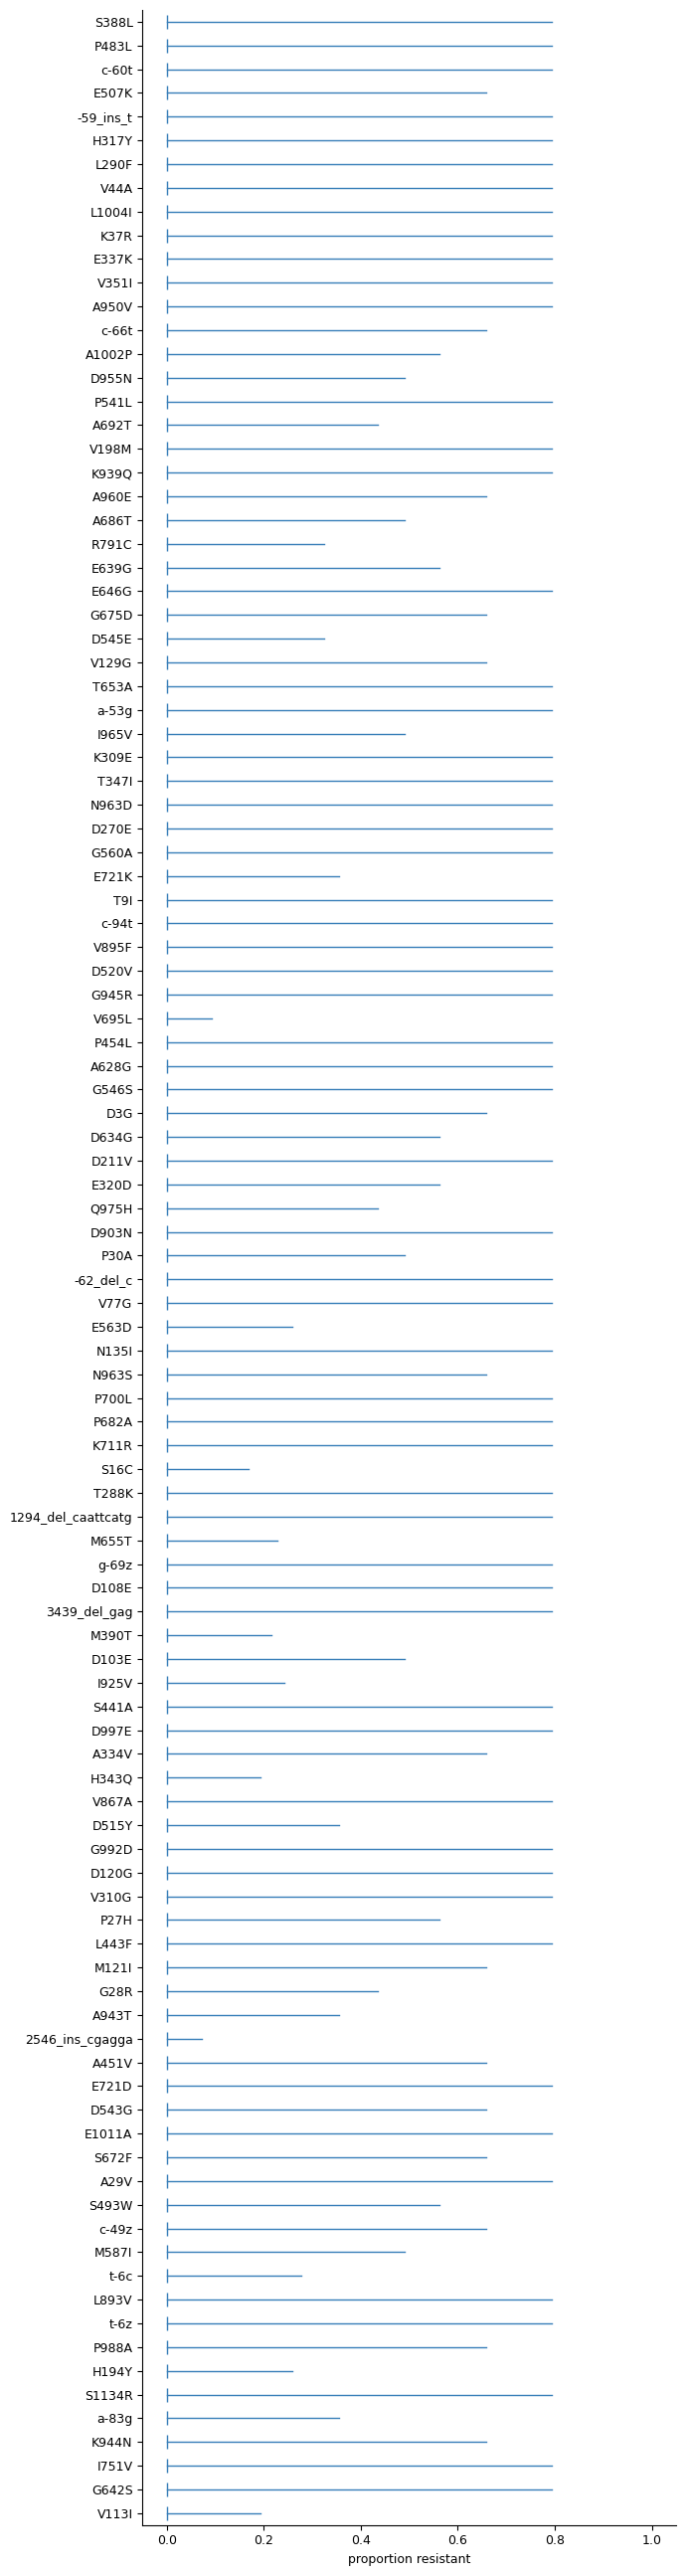

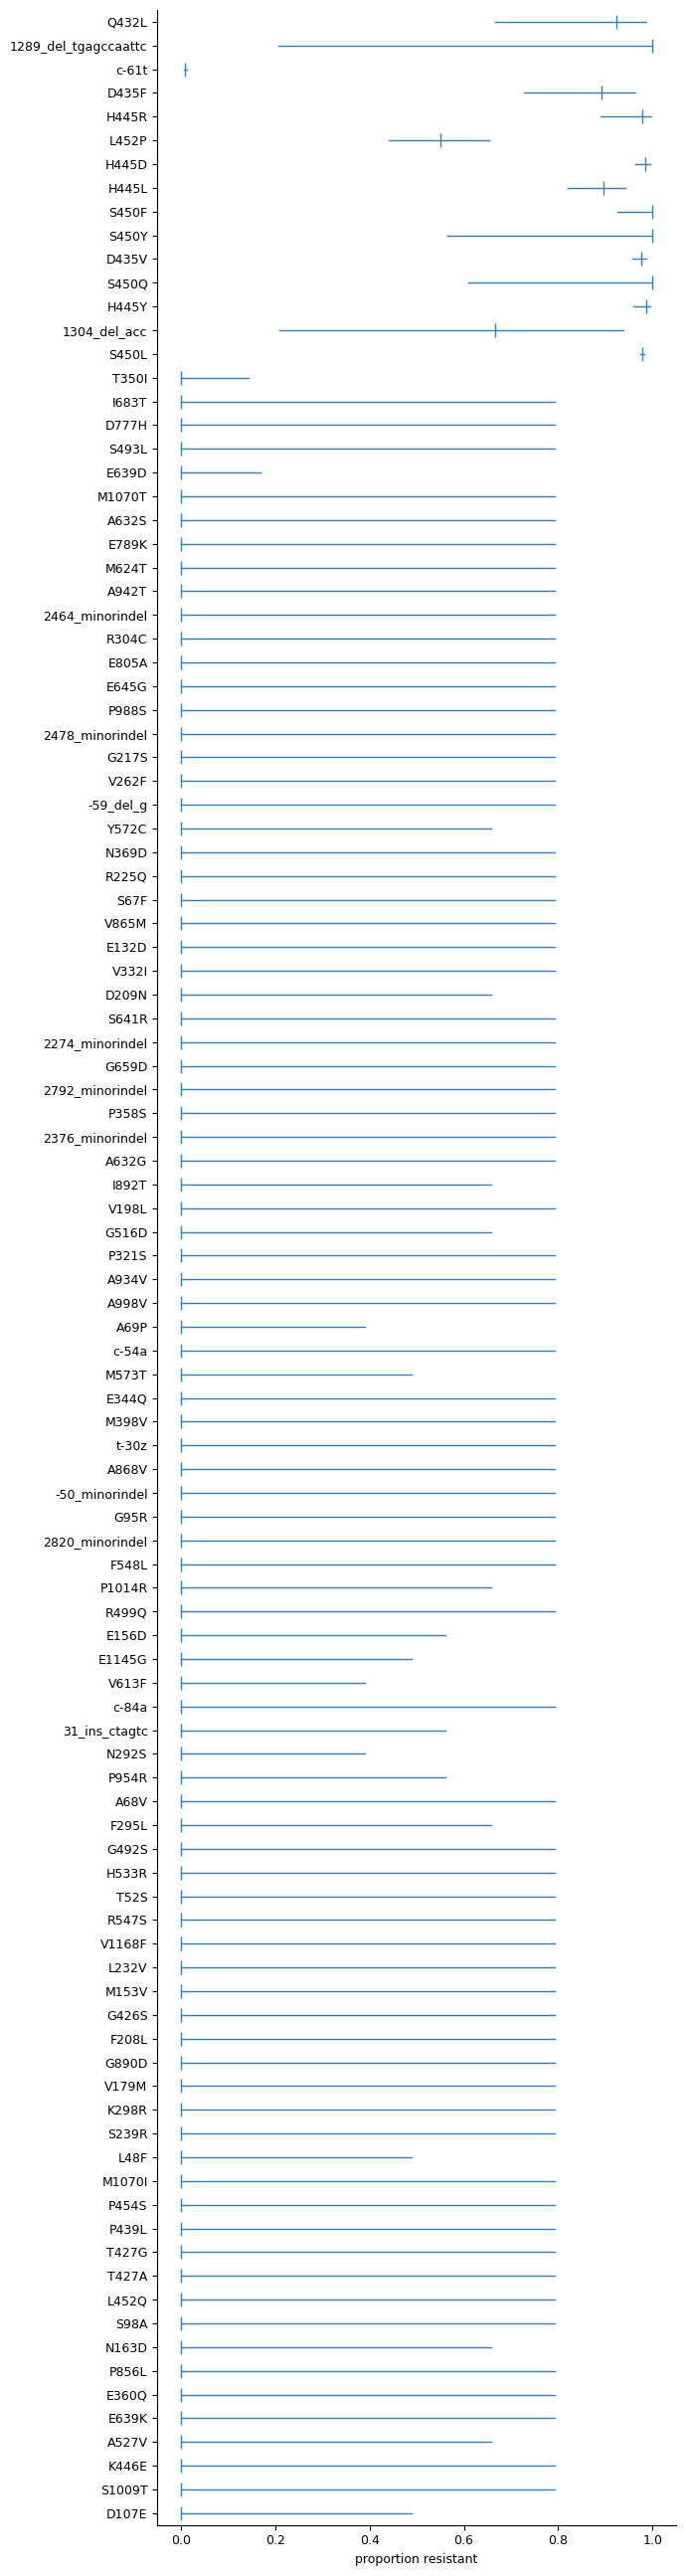

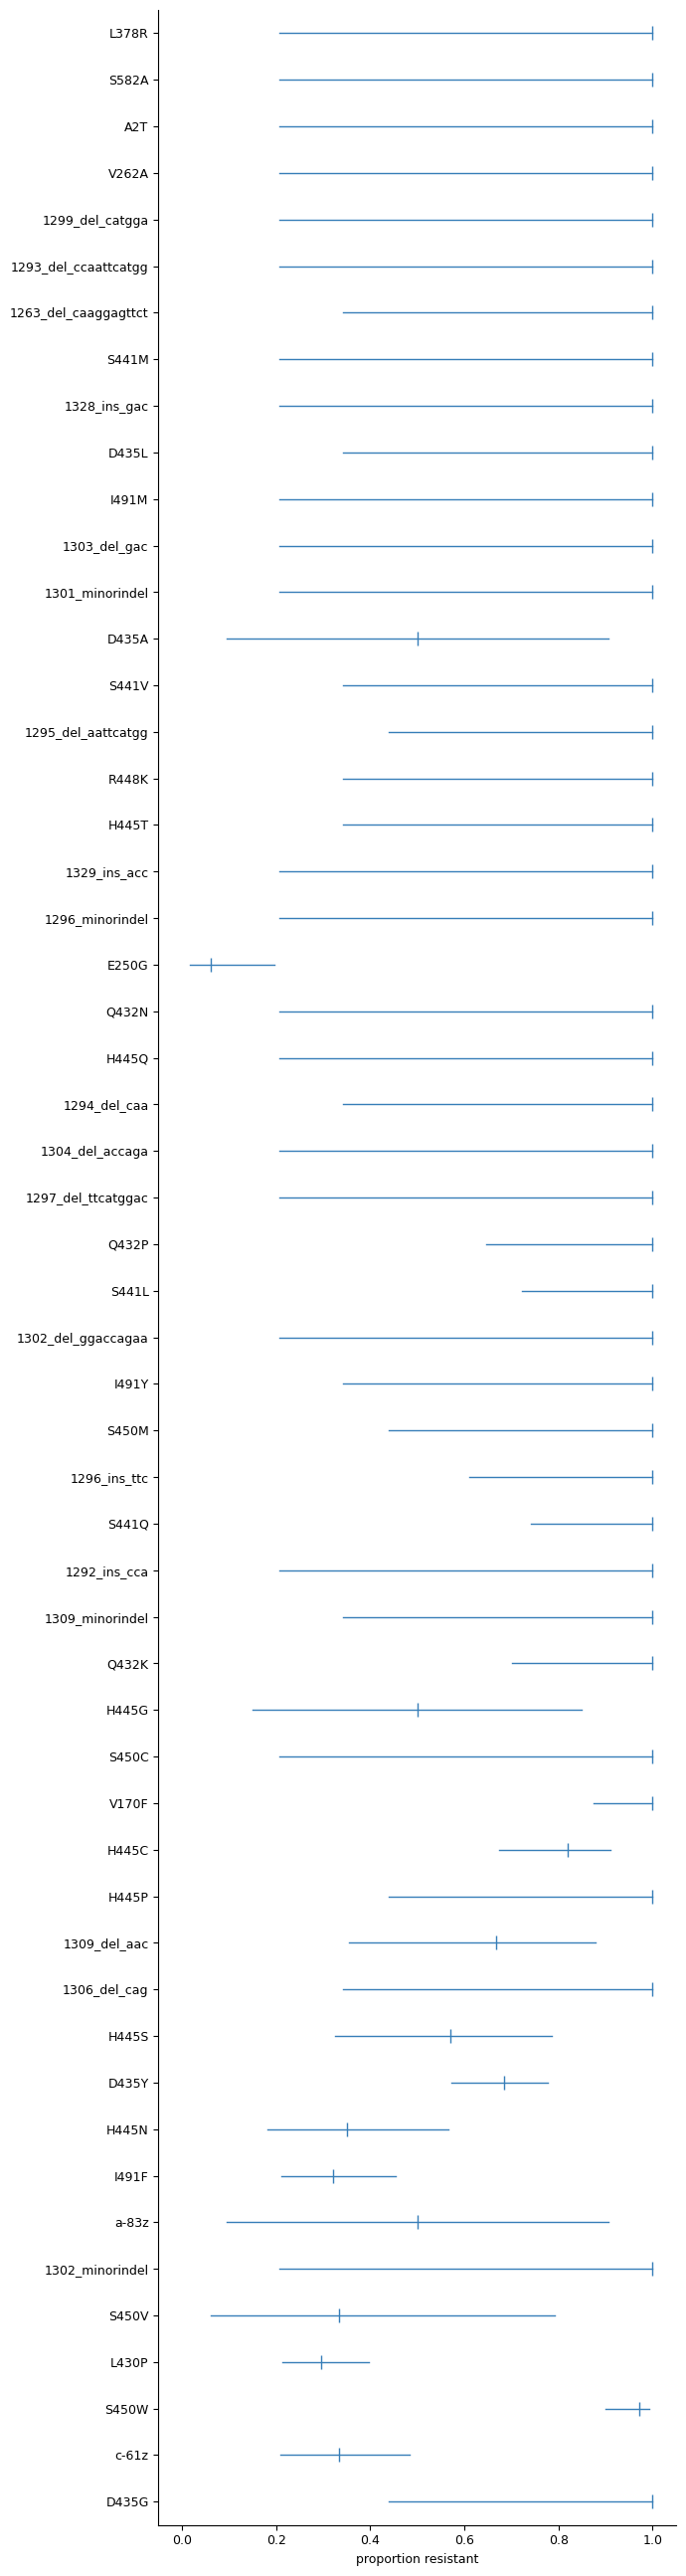

In [609]:
utils.plot_catalogue_proportions(catalogue, figsize=(7, 26), order=False)


In [668]:
catalogue = BuildCatalogue(
    samples=samples,
    mutations=mutations,
    FRS=0.1,
    record_ids=False,
    tails='one',
    test='Binomial',
    p=0.95,
    background=0.05,
    seed=['C66T', 'G86A', 'E639D'],
    strict_unlock=True
)
catalogue = catalogue.build_piezo("NC_000962.3", f"RIF-2024.07", "1.1", "RIF", wildcards)

In [669]:
catalogue.PREDICTION.value_counts()

PREDICTION
S    243
R     70
U      5
Name: count, dtype: int64

In [670]:
catalogue

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
0,NC_000962.3,RIF-2024.07,1.1,GARC1,RUS,RIF,C66T,S,{},"{""seeded"": ""True""}",{}
1,NC_000962.3,RIF-2024.07,1.1,GARC1,RUS,RIF,G86A,S,{},"{""seeded"": ""True""}",{}
2,NC_000962.3,RIF-2024.07,1.1,GARC1,RUS,RIF,E639D,S,{},"{""seeded"": ""True""}",{}
3,NC_000962.3,RIF-2024.07,1.1,GARC1,RUS,RIF,c-61t,S,{},"[{""proportion"": 0.008540925266903915, ""confide...",{}
4,NC_000962.3,RIF-2024.07,1.1,GARC1,RUS,RIF,V113I,S,{},"[{""proportion"": 0.0, ""confidence"": [0.0, 0.193...",{}
...,...,...,...,...,...,...,...,...,...,...,...
313,NC_000962.3,RIF-2024.07,1.1,GARC1,RUS,RIF,rpoB@-*_indel,U,{},{},{}
314,NC_000962.3,RIF-2024.07,1.1,GARC1,RUS,RIF,rpoB@*_indel,U,{},{},{}
315,NC_000962.3,RIF-2024.07,1.1,GARC1,RUS,RIF,rpoB@-*?,U,{},{},{}
316,NC_000962.3,RIF-2024.07,1.1,GARC1,RUS,RIF,rpoB@*?,U,{},{},{}


Doesnt look like we can squeeze too many R mutations out, but a Fishers exact does give us 23 additional RAVs and fewer S mutations, which may work in our favour...

Create feature set and train a repeated k fold model - seel if the additional R mutations has helped.

THen work out where false negatives and positives are coming from - ie, what are they. Could tally how many false negatives/positives we see for each mutation when the model is traind ~100 times.

I suspect the issue is how small the validation set is, and that any mutations in the validation set that are not in the RRDR will bomb sensitivity.

In [671]:
# Convert evidence entries to dicts, and remove wildcard rows
evidence = catalogue['EVIDENCE'].apply(utils.str_to_dict)

df = catalogue[['MUTATION', 'PREDICTION']].rename(columns={'MUTATION':'mutation', 'PREDICTION':'phenotype'})
df = df[~df['mutation'].str.contains(r'_|\!|\*')]
df['resid'] = [int(i[1:-1]) for i in df.mutation]
df['segid'] = 'C'
df = df[(df['resid']>=22) & (df['resid']<=1147)].reset_index()

In [672]:
df

,index,mutation,phenotype,resid,segid
0,0,C66T,S,66,C
1,1,G86A,S,86,C
2,2,E639D,S,639,C
3,4,V113I,S,113,C
4,5,G642S,S,642,C
...,...,...,...,...,...
241,304,S441W,R,441,C
242,307,M434I,R,434,C
243,308,V262A,R,262,C
244,310,S582A,R,582,C


In [673]:
df.phenotype.value_counts()

phenotype
S    202
R     44
U      0
Name: count, dtype: int64

Does this mutation set contain the false negative samples in the original?

In [674]:
df[df.mutation.isin(FN_mutations)]

,index,mutation,phenotype,resid,segid
88,105,K37R,S,37,C
243,308,V262A,R,262,C


Only contains 2 of the false negative mutaitons from above, which is pretty good. Let's build a feature set, and then train and test a model.

In [675]:
features = sbmlcore.FeatureDataset(df, protein="RNAP", species="M. tuberculosis", gene="rpoB")
volume = sbmlcore.AminoAcidVolumeChange()
hydropathy = sbmlcore.AminoAcidHydropathyChangeKyteDoolittle()
mw = sbmlcore.AminoAcidMWChange()
pi = sbmlcore.AminoAcidPiChange()
rogov = sbmlcore.AminoAcidRogovChange()
features.add_feature([volume, hydropathy, mw, pi, rogov])
rif_distance = sbmlcore.StructuralDistances('./data/pdb/5uh6.pdb','resname RFP', 'Rif_distance', infer_masses=True, offsets = {"C": -6})
mg_distance = sbmlcore.StructuralDistances('./data/pdb/5uh6.pdb','resname MG', 'Mg_distance', infer_masses=True, offsets = {"C": -6})
zn1_distance = sbmlcore.StructuralDistances('./data/pdb/5uh6.pdb','index 26082 and resname ZN', 'Zn1_distance', infer_masses=True, offsets = {"C": -6})
zn2_distance = sbmlcore.StructuralDistances('./data/pdb/5uh6.pdb','index 26083 and resname ZN', 'Zn2_distance', infer_masses=True, offsets = {"C": -6})
antisense_p_distance = sbmlcore.StructuralDistances('./data/pdb/5uh6.pdb','segid G and name P', 'antisense_P_distance', infer_masses=True, offsets = {"C": -6})
sense_p_distance = sbmlcore.StructuralDistances('./data/pdb/5uh6.pdb','segid H and name P', 'sense_P_distance', infer_masses=True, offsets = {"C": -6})
rna_distance = sbmlcore.StructuralDistances('./data/pdb/5uh6.pdb','segid I', 'RNA_distance', infer_masses=True, offsets = {"C": -6})
features.add_feature([rif_distance, mg_distance, zn1_distance, zn2_distance, antisense_p_distance, sense_p_distance, rna_distance])
stride = sbmlcore.Stride("./data/pdb/5uh6-peptide-only.pdb", offsets={'A': 0, 'B': 0, 'C':-6, 'D':0, 'E':0, 'F':0})
freesasa = sbmlcore.FreeSASA("./data/pdb/5uh6.pdb", offsets = {'C':-6})
snap2 = sbmlcore.SNAP2("./data/stride/5uh6-complete.csv", offsets={'A': 0, 'B': 0, 'C':-6, 'D':0, 'E':0, 'F':0})
deepddg = sbmlcore.DeepDDG("./data/ddg/5uh6.ddg", offsets={'A': 0, 'B': 0, 'C':-6, 'D':0, 'E':0, 'F':0})
rasp = sbmlcore.RaSP("./data/rasp/cavity_pred_5uh6_C.csv", offsets = {'C':-6})
temp = sbmlcore.TempFactors("./data/pdb/5uh6.pdb", offsets={'A': 0, 'B': 0, 'C':-6, 'D':0, 'E':0, 'F':0})
features.add_feature([stride, freesasa, snap2, deepddg, rasp, temp])

/Users/dylanadlard/miniforge3/envs/rif_manuscript/lib/python3.12/site-packages/sbmlcore/ExternalCode.py:313: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  snap2_df['Expected Accuracy'].replace(to_replace='%', value='', regex=True, inplace=True)


In [676]:
features.df[features.df['T'].isna()]

,segid,index,mutation,phenotype,d_volume,d_hydropathy_KD,d_MW,d_Pi,d_rogov,Rif_distance,...,T,SASA,snap2_score,snap2_accuracy,deep_ddG,rasp_wt_nlf,rasp_mt_nlf,rasp_score_ml_fermi,rasp_score_ml,temp_factor
0,C,0,C66T,S,7.6,-3.2,-2.1,0.53,-0.156,NaN,...,NaN,0.0,-31,66,NaN,NaN,NaN,NaN,NaN,NaN
1,C,1,G86A,S,28.5,2.2,14.0,0.03,-0.023,NaN,...,NaN,0.0,20,63,NaN,NaN,NaN,NaN,NaN,NaN


Not all of these mutations have gone through external software - we need to filter out these 2 (for now, will run them through later) 

In [677]:
features.df = features.df.dropna(subset=['T'])

In [678]:
features.df

,segid,index,mutation,phenotype,d_volume,d_hydropathy_KD,d_MW,d_Pi,d_rogov,Rif_distance,...,T,SASA,snap2_score,snap2_accuracy,deep_ddG,rasp_wt_nlf,rasp_mt_nlf,rasp_score_ml_fermi,rasp_score_ml,temp_factor
2,C,2,E639D,S,-27.3,0.0,-14.0,-0.45,0.109,34.015193,...,True,107.910414,50,75,-0.152,2.712832,2.824680,0.254674,0.315403,41.400002
3,C,4,V113I,S,26.7,0.3,14.1,0.06,0.494,24.626817,...,False,46.996241,-95,97,0.471,2.623741,2.854018,0.222572,-0.126852,36.919998
4,C,5,G642S,S,28.9,-0.4,30.0,-0.29,0.120,42.448172,...,False,0.226439,48,71,-2.495,2.560213,2.844502,0.548394,3.485464,32.490002
5,C,6,I751V,S,-26.7,-0.3,-14.1,-0.06,0.494,27.986912,...,False,23.895392,-91,97,-0.242,2.854018,2.623741,0.287591,0.732213,19.900000
6,C,7,K944N,S,-54.5,0.4,-14.1,-4.33,0.197,59.941562,...,True,208.845293,-73,87,0.025,2.828313,3.127102,0.215516,-0.229982,86.489998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,C,304,S441W,R,138.8,-0.1,99.1,0.21,-0.249,12.678794,...,False,0.000000,67,80,-1.054,2.844502,4.250501,0.326438,1.189145,16.580000
242,C,307,M434I,R,3.8,2.6,-18.0,0.28,-0.452,9.843524,...,False,7.242104,93,95,-1.393,3.785957,2.854018,0.290369,0.766023,17.299999
243,C,308,V262A,R,-51.4,-2.4,-28.0,0.04,0.232,56.595298,...,False,95.032454,-82,93,-0.214,2.623741,2.483982,0.275822,0.586795,133.350006
244,C,310,S582A,R,-0.4,2.6,-16.0,0.32,0.249,18.638826,...,True,0.000000,29,63,-1.548,2.844502,2.483982,0.237018,0.077250,18.350000


In [679]:
features.df['secondary_structure_codes'] = pd.Categorical(features.df.secondary_structure, categories=features.df.secondary_structure.unique()).codes
features.df = features.df.drop(columns=["secondary_structure","secondary_structure_long","B","C","E","G","H","T"])
features.df = features.df.drop(columns=["residue_sasa","snap2_accuracy","rasp_wt_nlf","rasp_mt_nlf","rasp_score_ml"])
features.df = features.df.rename(columns={"d_Pi":"d_pi", "rasp_score_ml_fermi":"rasp_score", "secondary_structure_codes":"secondary_structure"})
df = features.df
df

,segid,index,mutation,phenotype,d_volume,d_hydropathy_KD,d_MW,d_pi,d_rogov,Rif_distance,...,phi,psi,n_hbond_acceptors,n_hbond_donors,SASA,snap2_score,deep_ddG,rasp_score,temp_factor,secondary_structure
2,C,2,E639D,S,-27.3,0.0,-14.0,-0.45,0.109,34.015193,...,-72.58,-54.68,0.0,0.0,107.910414,50,-0.152,0.254674,41.400002,0
3,C,4,V113I,S,26.7,0.3,14.1,0.06,0.494,24.626817,...,-55.57,-55.02,2.0,0.0,46.996241,-95,0.471,0.222572,36.919998,1
4,C,5,G642S,S,28.9,-0.4,30.0,-0.29,0.120,42.448172,...,169.90,-149.75,1.0,1.0,0.226439,48,-2.495,0.548394,32.490002,2
5,C,6,I751V,S,-26.7,-0.3,-14.1,-0.06,0.494,27.986912,...,-161.65,154.98,1.0,1.0,23.895392,-91,-0.242,0.287591,19.900000,2
6,C,7,K944N,S,-54.5,0.4,-14.1,-4.33,0.197,59.941562,...,60.77,28.12,0.0,0.0,208.845293,-73,0.025,0.215516,86.489998,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,C,304,S441W,R,138.8,-0.1,99.1,0.21,-0.249,12.678794,...,-55.13,-41.96,2.0,1.0,0.000000,67,-1.054,0.326438,16.580000,1
242,C,307,M434I,R,3.8,2.6,-18.0,0.28,-0.452,9.843524,...,-62.15,126.41,0.0,1.0,7.242104,93,-1.393,0.290369,17.299999,3
243,C,308,V262A,R,-51.4,-2.4,-28.0,0.04,0.232,56.595298,...,-126.69,153.98,0.0,0.0,95.032454,-82,-0.214,0.275822,133.350006,3
244,C,310,S582A,R,-0.4,2.6,-16.0,0.32,0.249,18.638826,...,-95.24,-170.26,1.0,0.0,0.000000,29,-1.548,0.237018,18.350000,0


In [680]:
data = df.copy()

#replace R/S labels with binary 1/0
data['phenotype'] = [1 if i =='R' else 0 for i in data.phenotype]
#remove dynamic features generated from md simulations - will explore later
data = data.drop(columns=[col for col in data.columns if 'min' in col or 'mean' in col])

data

,segid,index,mutation,phenotype,d_volume,d_hydropathy_KD,d_MW,d_pi,d_rogov,Rif_distance,...,phi,psi,n_hbond_acceptors,n_hbond_donors,SASA,snap2_score,deep_ddG,rasp_score,temp_factor,secondary_structure
2,C,2,E639D,0,-27.3,0.0,-14.0,-0.45,0.109,34.015193,...,-72.58,-54.68,0.0,0.0,107.910414,50,-0.152,0.254674,41.400002,0
3,C,4,V113I,0,26.7,0.3,14.1,0.06,0.494,24.626817,...,-55.57,-55.02,2.0,0.0,46.996241,-95,0.471,0.222572,36.919998,1
4,C,5,G642S,0,28.9,-0.4,30.0,-0.29,0.120,42.448172,...,169.90,-149.75,1.0,1.0,0.226439,48,-2.495,0.548394,32.490002,2
5,C,6,I751V,0,-26.7,-0.3,-14.1,-0.06,0.494,27.986912,...,-161.65,154.98,1.0,1.0,23.895392,-91,-0.242,0.287591,19.900000,2
6,C,7,K944N,0,-54.5,0.4,-14.1,-4.33,0.197,59.941562,...,60.77,28.12,0.0,0.0,208.845293,-73,0.025,0.215516,86.489998,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,C,304,S441W,1,138.8,-0.1,99.1,0.21,-0.249,12.678794,...,-55.13,-41.96,2.0,1.0,0.000000,67,-1.054,0.326438,16.580000,1
242,C,307,M434I,1,3.8,2.6,-18.0,0.28,-0.452,9.843524,...,-62.15,126.41,0.0,1.0,7.242104,93,-1.393,0.290369,17.299999,3
243,C,308,V262A,1,-51.4,-2.4,-28.0,0.04,0.232,56.595298,...,-126.69,153.98,0.0,0.0,95.032454,-82,-0.214,0.275822,133.350006,3
244,C,310,S582A,1,-0.4,2.6,-16.0,0.32,0.249,18.638826,...,-95.24,-170.26,1.0,0.0,0.000000,29,-1.548,0.237018,18.350000,0


In [681]:
feature_data = data[data.columns[4:]]
feature_data['phenotype'] = data.phenotype

#use ml-models to determine best model and decision threshold, on most data - gives us something to work with
model = Models(
        {"all": feature_data},
        'LR',
        "average_precision",
        random_seed=0,
        test_fraction=0.1,
        verbose=False,
        output_plots=False,
    )

est = model.opt_estimator
thresh = model.opt_threshold

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_11118/2467135004.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_data['phenotype'] = data.phenotype


In [682]:
feature_data

,d_volume,d_hydropathy_KD,d_MW,d_pi,d_rogov,Rif_distance,Mg_distance,Zn1_distance,Zn2_distance,antisense_P_distance,...,psi,n_hbond_acceptors,n_hbond_donors,SASA,snap2_score,deep_ddG,rasp_score,temp_factor,secondary_structure,phenotype
2,-27.3,0.0,-14.0,-0.45,0.109,34.015193,46.989545,87.166478,75.548089,55.623614,...,-54.68,0.0,0.0,107.910414,50,-0.152,0.254674,41.400002,0,0
3,26.7,0.3,14.1,0.06,0.494,24.626817,41.825588,78.262390,57.362562,45.086377,...,-55.02,2.0,0.0,46.996241,-95,0.471,0.222572,36.919998,1,0
4,28.9,-0.4,30.0,-0.29,0.120,42.448172,53.093099,94.241454,82.538298,64.371499,...,-149.75,1.0,1.0,0.226439,48,-2.495,0.548394,32.490002,2,0
5,-26.7,-0.3,-14.1,-0.06,0.494,27.986912,38.493729,67.273466,37.702159,41.556539,...,154.98,1.0,1.0,23.895392,-91,-0.242,0.287591,19.900000,2,0
6,-54.5,0.4,-14.1,-4.33,0.197,59.941562,53.890413,88.529532,110.782258,74.331578,...,28.12,0.0,0.0,208.845293,-73,0.025,0.215516,86.489998,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,138.8,-0.1,99.1,0.21,-0.249,12.678794,23.187511,62.852345,62.343591,34.163870,...,-41.96,2.0,1.0,0.000000,67,-1.054,0.326438,16.580000,1,1
242,3.8,2.6,-18.0,0.28,-0.452,9.843524,27.300241,63.742282,55.067065,31.789556,...,126.41,0.0,1.0,7.242104,93,-1.393,0.290369,17.299999,3,1
243,-51.4,-2.4,-28.0,0.04,0.232,56.595298,69.461383,76.087975,80.241269,46.536821,...,153.98,0.0,0.0,95.032454,-82,-0.214,0.275822,133.350006,3,1
244,-0.4,2.6,-16.0,0.32,0.249,18.638826,26.587542,64.049947,71.927826,35.219514,...,-170.26,1.0,0.0,0.000000,29,-1.548,0.237018,18.350000,0,1


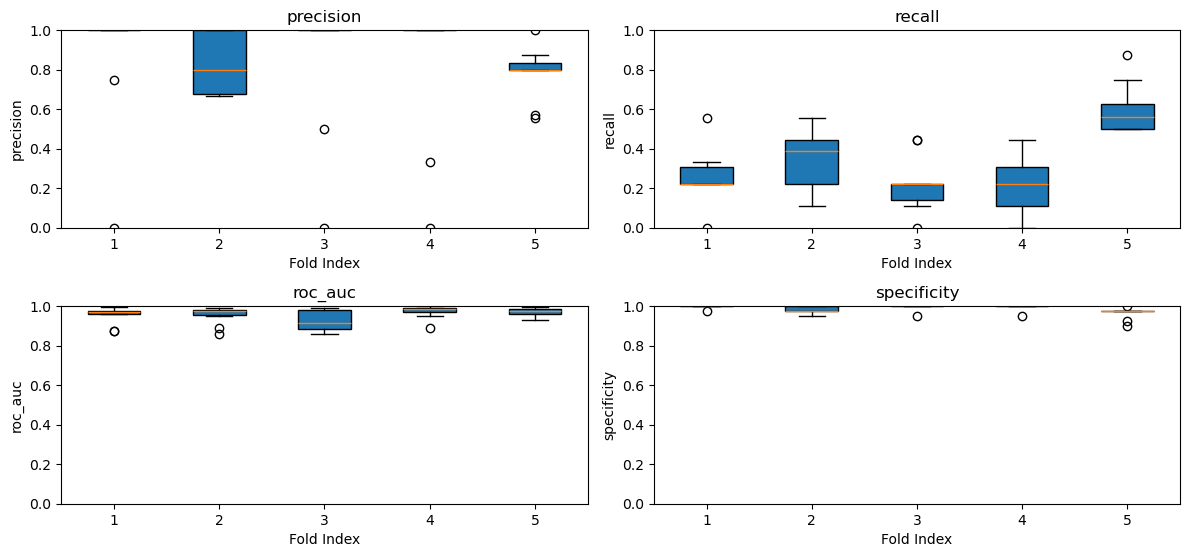

In [683]:
X = feature_data.drop(columns=['phenotype'])
y = feature_data['phenotype']

metrics = utils.repeated_kfold_evaluation(est, X, y, threshold=thresh, n_splits=5, n_repeats=10)

# Plot the results
plt.figure(figsize=(12, 8))

num_metrics = len(metrics)
for idx, metric in enumerate(metrics):
    plt.subplot(3, 2, idx+1)
    plt.boxplot(metrics[metric], notch=False, patch_artist=True)
    plt.title(metric)
    plt.xlabel('Fold Index')
    plt.ylim(0, 1)
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

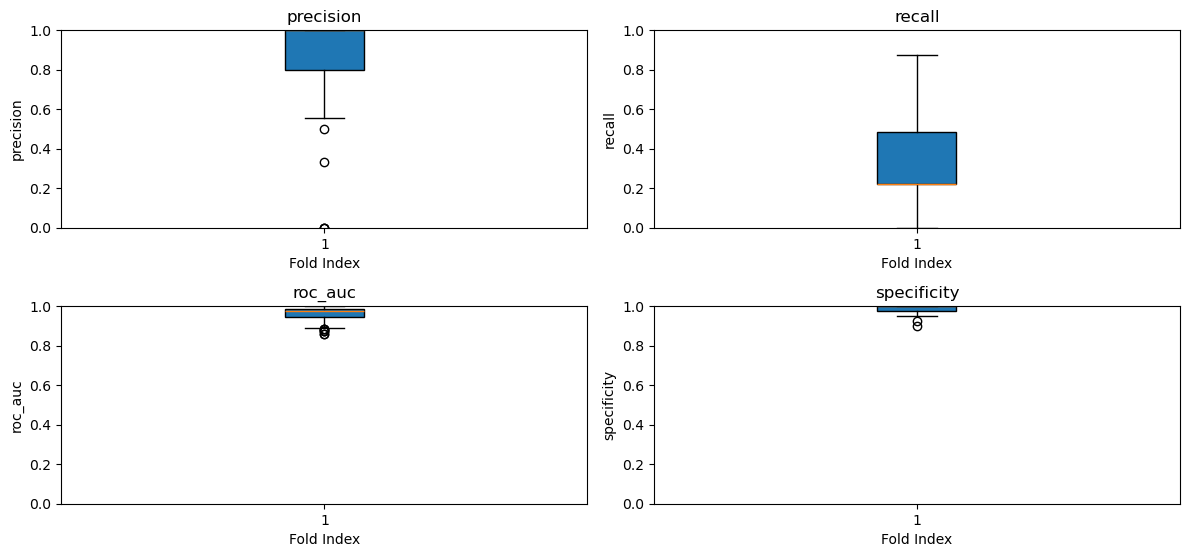

In [684]:
metrics = {metric: [item for sublist in values for item in sublist] for metric, values in metrics.items()}

# Plot the results
plt.figure(figsize=(12, 8))

num_metrics = len(metrics)
for idx, metric in enumerate(metrics):
    plt.subplot(3, 2, idx+1)
    plt.boxplot(metrics[metric], notch=False, patch_artist=True)
    plt.title(metric)
    plt.xlabel('Fold Index')
    plt.ylim(0, 1)
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

/Users/dylanadlard/miniforge3/envs/rif_manuscript/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/Users/dylanadlard/miniforge3/envs/rif_manuscript/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dylanadlard/miniforge3/envs/rif_manuscript/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

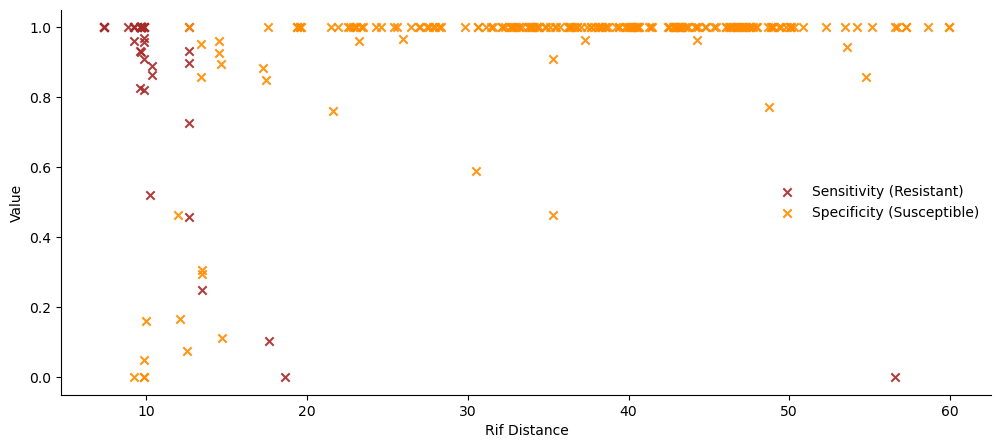

In [685]:
# Initialize the dictionary for all mutations
mutation_stats = {mut: {'FP': 0, 'FN': 0, 'TN':0, 'TP':0} for mut in data['mutation']}

# Initialize model and other necessary variables (assuming Models is defined)
for i in range(0, 100):
    model = Models(
        {"all": feature_data},
        "LR",
        "average_precision",
        random_seed=i,
        test_fraction=0.25,
        verbose=False,
        output_plots=False,
        upsample_coeff=0,
    )

    X_train, y_train, X_test, y_test = (
        model.X_train_nd["all"],
        model.y_train_nd["all"],
        model.X_test_nd["all"],
        model.y_test_nd["all"],
    )
    est = model.opt_estimator
    thresh = model.opt_threshold

    est.fit(X_train, y_train)
    y_proba = est.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= thresh).astype(int)

    X_test_df = pd.DataFrame(X_test)
    X_test_df.columns = feature_data.drop(columns=['phenotype']).columns
    X_test_df.reset_index(drop=True, inplace=True)

    # Add predictions and true values to the test DataFrame
    X_test_df['y_test'] = y_test
    X_test_df['y_pred'] = y_pred

    # Identify false positives and false negatives using boolean indexing
    TNs_df =  X_test_df[(X_test_df['y_test'] == 0) & (X_test_df['y_pred'] == 0)]
    TPs_df =  X_test_df[(X_test_df['y_test'] == 1) & (X_test_df['y_pred'] == 1)]
    FPs_df = X_test_df[(X_test_df['y_test'] == 0) & (X_test_df['y_pred'] == 1)]
    FNs_df = X_test_df[(X_test_df['y_test'] == 1) & (X_test_df['y_pred'] == 0)]

    # Merge with feature_data to include the 'mutation' column
    FPs_merged = pd.merge(FPs_df, data, on=['d_volume', 'Rif_distance', 'Zn1_distance'], how='left')
    FNs_merged = pd.merge(FNs_df, data, on=['d_volume', 'Rif_distance', 'Zn1_distance'], how='left')
    TPs_merged = pd.merge(TPs_df, data, on=['d_volume', 'Rif_distance', 'Zn1_distance'], how='left')
    TNs_merged = pd.merge(TNs_df, data, on=['d_volume', 'Rif_distance', 'Zn1_distance'], how='left')

    # Update the mutation statistics dictionary
    for mut in TPs_merged['mutation']:
        mutation_stats[mut]['TP'] += 1

    for mut in TNs_merged['mutation']:
        mutation_stats[mut]['TN'] += 1

    for mut in FPs_merged['mutation']:
        mutation_stats[mut]['FP'] += 1

    for mut in FNs_merged['mutation']:
        mutation_stats[mut]['FN'] += 1

stats_df = pd.DataFrame(mutation_stats).T.reset_index().rename(columns={'index':'mutation'})
stats_df = pd.merge(stats_df, data[['mutation', 'Rif_distance', 'phenotype']], on=['mutation'], how='left')

# Define functions to calculate sensitivity and specificity
def calculate_sensitivity(tp, fn):
    if tp + fn == 0:
        return float('NaN')
    return tp / (tp + fn)

def calculate_specificity(tn, fp):
    if tn + fp == 0:
        return float('NaN')
    return tn / (tn + fp)

# Apply calculations
sensitivities = []
specificities = []

for index, row in stats_df.iterrows():
    if row['phenotype'] == 1:  # Resistant
        sensitivity = calculate_sensitivity(row['TP'], row['FN'])
        sensitivities.append(sensitivity)
        specificities.append(float('NaN'))
    elif row['phenotype'] == 0:  # Susceptible
        specificity = calculate_specificity(row['TN'], row['FP'])
        specificities.append(specificity)
        sensitivities.append(float('NaN'))

stats_df['Sensitivity'] = sensitivities
stats_df['Specificity'] = specificities


# Separate data
resistant_mutations = stats_df[stats_df['phenotype'] == 1]
susceptible_mutations = stats_df[stats_df['phenotype'] == 0]

# Create the plot
plt.figure(figsize=(12, 5))
plt.scatter(resistant_mutations['Rif_distance'], resistant_mutations['Sensitivity'], marker='x', color='brown', label='Sensitivity (Resistant)', alpha=0.9)
plt.scatter(susceptible_mutations['Rif_distance'], susceptible_mutations['Specificity'], marker='x', color='darkOrange', label='Specificity (Susceptible)', alpha=0.9)

plt.xlabel('Rif Distance')
plt.ylabel('Value')

# Customize legend
legend = plt.legend()
legend.get_frame().set_linewidth(0)  # Remove legend frame

# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Remove grid lines
plt.grid(False)

plt.show()

In [690]:
stats_df[stats_df.Specificity<0.8]

,mutation,FP,FN,TN,TP,Rif_distance,phenotype,Sensitivity,Specificity
9,S450V,21,0,0,0,9.880496,0,NaN,0.000000
11,S493W,19,0,8,0,13.468693,0,NaN,0.296296
17,A451V,20,0,4,0,12.083085,0,NaN,0.166667
21,L443F,24,0,3,0,14.703586,0,NaN,0.111111
52,D435A,25,0,0,0,9.263286,0,NaN,0.000000
53,D634G,6,0,19,0,21.637517,0,NaN,0.760000
92,P483L,26,0,5,0,9.963034,0,NaN,0.161290
95,K446E,25,0,2,0,12.505878,0,NaN,0.074074
102,L452Q,17,0,0,0,9.845697,0,NaN,0.000000
112,G890D,14,0,20,0,30.511789,0,NaN,0.588235


In [687]:
catalogue[catalogue.MUTATION.isin(stats_df[stats_df.Sensitivity<0.5].mutation)]

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
292,NC_000962.3,RIF-2024.07,1.1,GARC1,RUS,RIF,S441V,R,{},"[{""proportion"": 1.0, ""confidence"": [0.34238022...",{}
303,NC_000962.3,RIF-2024.07,1.1,GARC1,RUS,RIF,S493R,R,{},"[{""proportion"": 1.0, ""confidence"": [0.20654931...",{}
308,NC_000962.3,RIF-2024.07,1.1,GARC1,RUS,RIF,V262A,R,{},"[{""proportion"": 1.0, ""confidence"": [0.20654931...",{}
310,NC_000962.3,RIF-2024.07,1.1,GARC1,RUS,RIF,S582A,R,{},"[{""proportion"": 1.0, ""confidence"": [0.20654931...",{}
311,NC_000962.3,RIF-2024.07,1.1,GARC1,RUS,RIF,L378R,R,{},"[{""proportion"": 1.0, ""confidence"": [0.20654931...",{}


In [688]:
catalogue[catalogue.MUTATION.isin([['A286V',
 'D571Y',
 'D595E',
 'G981D',
 'K37R',
 'K891T',
 'L232R',
 'M707T',
 'Q409R',
 'V262A',
 'V496M',
 'Y308C']])]

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER


catalogue[catalogue.MUTATION.isin(stats_df[stats_df.Sensitivity==0].mutation)]